In [1]:
pip install pandas numpy scikit-learn imbalanced-learn nltk sastrawi wordcloud matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re

In [4]:
data = pd.read_csv('/kaggle/input/satusehat-reviews/satusehat_reviews.csv')

In [5]:
def create_label(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'

data['label'] = data['score'].apply(create_label)

# 3. Preprocessing (Sama dengan sebelumnya)
def cleansing(text):
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    return text

def casefolding(text):
    return text.lower()

def tokenize(text):
    return word_tokenize(text)

stop_words = set(stopwords.words('indonesian'))
def filtering(tokens):
    return [word for word in tokens if word not in stop_words]

factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming(tokens):
    return [stemmer.stem(word) for word in tokens]

def preprocess(text):
    text = cleansing(text)
    text = casefolding(text)
    tokens = tokenize(text)
    tokens = filtering(tokens)
    tokens = stemming(tokens)
    return ' '.join(tokens)

data['processed_text'] = data['content'].apply(preprocess)


In [6]:
# 4. SMOTE untuk Multi-Kelas
X = data['processed_text']
y = data['label']

# TF-IDF Feature Extraction
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X).toarray()

# Lakukan SMOTE (Mendukung multi-kelas)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

In [7]:
# 5. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.2, 
    random_state=42,
    stratify=y_resampled  # Stratifikasi untuk menjaga distribusi kelas
)


In [8]:
# 6. Modeling dan Evaluasi
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# SVM Model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
print("\n=== SVM Performance ===")
evaluate_model(svm_model, X_test, y_test)

# Naïve Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("\n=== Naïve Bayes Performance ===")
evaluate_model(nb_model, X_test, y_test)


=== SVM Performance ===
Accuracy: 0.941747572815534

Classification Report:
              precision    recall  f1-score   support

     negatif       0.99      0.84      0.91       480
      netral       0.91      0.99      0.95       481
     positif       0.94      0.99      0.97       481

    accuracy                           0.94      1442
   macro avg       0.95      0.94      0.94      1442
weighted avg       0.95      0.94      0.94      1442


Confusion Matrix:
[[402  48  30]
 [  2 478   1]
 [  3   0 478]]

=== Naïve Bayes Performance ===
Accuracy: 0.8841886269070736

Classification Report:
              precision    recall  f1-score   support

     negatif       0.94      0.73      0.82       480
      netral       0.83      0.95      0.89       481
     positif       0.90      0.97      0.93       481

    accuracy                           0.88      1442
   macro avg       0.89      0.88      0.88      1442
weighted avg       0.89      0.88      0.88      1442


Confusion

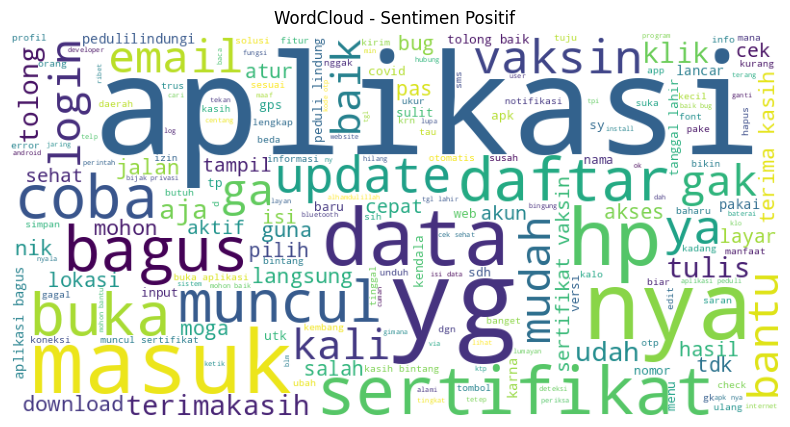

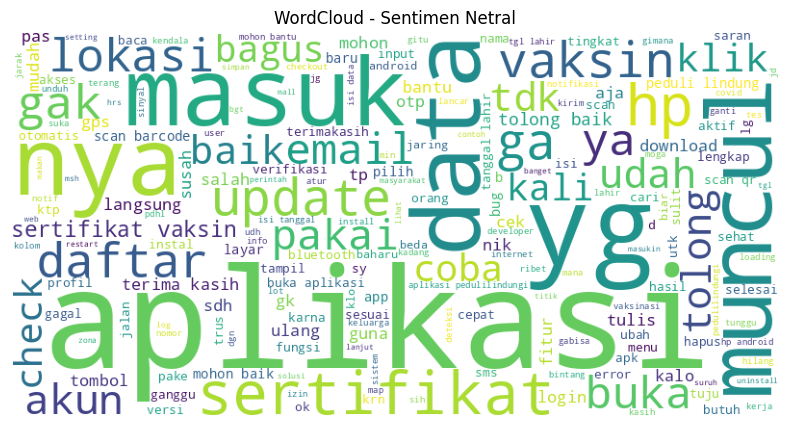

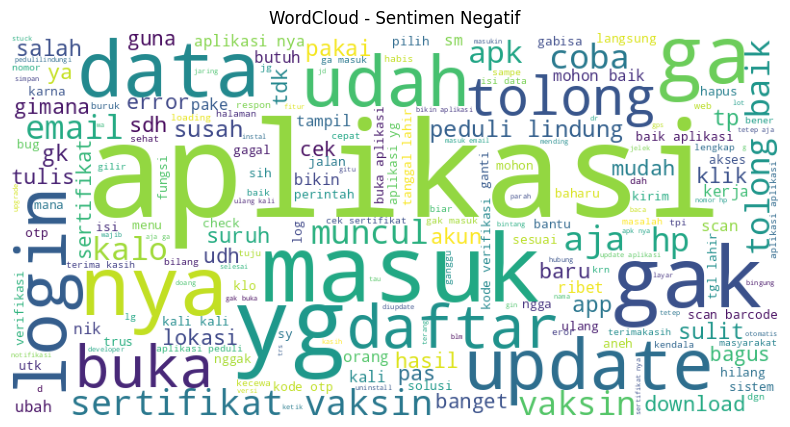

In [9]:
# 7. Visualisasi WordCloud untuk 3 Kelas
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap='viridis'  # Ubah colormap untuk visual berbeda
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Untuk setiap kelas
for label in ['positif', 'netral', 'negatif']:
    text = ' '.join(data[data['label'] == label]['processed_text'])
    plot_wordcloud(text, f"WordCloud - Sentimen {label.capitalize()}")